In [4]:
from typing import Pattern
import pandas as pd 
import numpy as np
import nltk
import csv
import re
from re import sub
import sys
from unidecode import unidecode

from nltk.corpus import stopwords 


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

In [5]:
path_init = "data/_57793TransmissionsSurvivors_2014.csv"
path_new_sentiments = "data/data_train.csv"

PATTERN_SUPP_HTML : Pattern = re.compile(r'<(.*?)>')
REPLACE_NO_SPACE : Pattern= re.compile(r"[.;:!=\%?,\"()\[\]]")
REPLACE_WITH_SPACE : Pattern = re.compile(r"(<br\s*/><br\s*/>)|(\-)|(\/)|°")

In [223]:
# nettoyer le texte 
def preprocess_clean(reviews):
    reviews = reviews.lower() # mettre le texte en minuscule

    reviews = re.sub(r'\bagrave\b', 'a', reviews) #replacer agrave par a (!à)
    reviews = re.sub(r'\beacut\b|\begrave\b|\bpreacute\b', 'e', reviews)#

    sub_html = re.findall(PATTERN_SUPP_HTML, reviews) #supprimer les balise html
    for html in sub_html:
        if html:
            reviews = re.sub(r'\s+', ' ', reviews)
            reviews = re.sub(r"\'", ' ', reviews)
            reviews = reviews.replace(html, ' ')
            reviews = reviews.replace('< >', ' ')

    reviews = REPLACE_NO_SPACE.sub(' ', reviews) #supprimer tout les caracteres [.;:!=\%?,\"()\[\]]
    reviews = REPLACE_WITH_SPACE.sub(' ', reviews) #supprimer espace entre balise html au cas où y'en a 
    reviews = reviews.replace('ttt', 'traitement') 
    reviews = re.sub(r"([+])", ' plus ', reviews)
    reviews = re.sub(r"([+])", ' ', reviews)
    reviews = re.sub(r'[0-9]', ' ', reviews)
    #reviews = re.sub(r'\b\w{1,3}\b',' ', reviews)

    reviews = re.sub(' +', ' ', reviews)#supprimer tout espace de plus qui peut exister à la fin de traitement
    #print(reviews)
    return reviews

In [229]:
def text_to_word_list(text, remove_polish_letters):
    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    text = remove_polish_letters(text)
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub('(\d)([a-zA-Z]+)', r'\1 \2', text)
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

In [7]:
df = pd.read_csv('2-data/NETREAD.NETSOINS_TRANSMISSIONS-Tableau 1.csv', encoding='utf-8', sep=";")
#df.libelle2 = df.libelle2.apply(lambda x: text_to_word_list(x, unidecode))
df.head(20)

,id_resident,id_etablissement,date_T,libelle2,Unnamed: 4
0,42973,557,1418663163,"Vue ce jour poursuite du suivi, Mme Cautain es...",NaN
1,25134,739,1416909807,ai posé la question au dr touggani concernant ...,NaN
2,28144,561,1418664063,tres agrssive en ce moment. surveillance sinon...,NaN
3,16416,650,1421399533,reeducation de membre superieur gauche et de l...,NaN
4,10272,670,1418085149,Elle n'arrète pas de m'appeler sur le téléhone...,NaN
5,32249,754,1420373845,suite,NaN
6,17265,544,1419890663,Soin : Collation Nuit : Refus,NaN
7,2130,432,1419916286,"Fait surveillance sat. : 88 % de sat. , 87 de ...",NaN
8,653,368,1418134120,D jambe gauche oedématiée rouge à sa base avec...,NaN
9,23750,664,1421252017,Me V. a eu des selles liquides ce matin en gra...,NaN


In [233]:
df_2 = df_test[['libelle2']]
df_2.head()

,libelle2
0,"Vue ce jour poursuite du suivi, Mme Cautain es..."
1,ai posé la question au dr touggani concernant ...
2,tres agrssive en ce moment. surveillance sinon...
3,reeducation de membre superieur gauche et de l...
4,Elle n'arrète pas de m'appeler sur le téléhone...


In [237]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sabbar/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [245]:
stopwords_french = stopwords.words('french')
len(stopwords_french)

157

In [5]:
data = df[['libelle2','sentiment', 'OK/KO']].to_numpy()

In [6]:
data_training = []
for descrp, senti, c_senti in data:
    if c_senti == '':
        c_senti = senti
        
    
    descrp = preprocess_clean(descrp) #.encode('utf-8').decode('utf-8')
    #descrp = unidecode(descrp)
    data_training.append((descrp, c_senti))
    #if len(data_training) >= 712: 
     #   break

In [7]:
df2 = pd.DataFrame(data_training, columns=['description', 'label'])
print(len(df2))
df2.head(10)


710


,description,label
0,je n'ai pas vu le pilulier,Negative
1,traitement non donné,Negative
2,j'ai retrouvé mr en train de pleurer ce soir i...,Negative
3,dr traolen est contacté aujourd'hui pour renou...,Neutre
4,les filles lui ont donné le laxatif suppositoire,Neutre
5,selles plus plus plus,Negative
6,remis à patricia fille de m prince ce jour les...,Positive
7,mr prince me qu'il a trés mal au dent il n'a p...,Negative
8,monsieur n'ayant pas eu de selles pendant troi...,Negative
9,absence de selle depuis plus de jorus,Negative


In [9]:
df2.to_csv('data-frame-csv-clean.csv', sep=';', encoding='utf-8')

In [12]:
df = pd.read_csv('data-frame-csv-clean.csv', encoding='utf-8', sep=";", na_filter=False)
df.head(10)

,Unnamed: 0,description,label
0,0,je n'ai pas vu le pilulier,Negative
1,1,traitement non donné,Negative
2,2,j'ai retrouvé mr en train de pleurer ce soir i...,Negative
3,3,dr traolen est contacté aujourd'hui pour renou...,PlandeSoins
4,4,les filles lui ont donné le laxatif suppositoire,PlandeSoins
5,5,selles plus plus plus,Negative
6,6,remis à patricia fille de m prince ce jour les...,Positive
7,7,mr prince me qu'il a trés mal au dent il n'a p...,Negative
8,8,monsieur n'ayant pas eu de selles pendant troi...,Negative
9,9,absence de selle depuis plus de jorus,Negative


In [24]:
#mix data + lable_num
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,Unnamed: 0,description,label,label_num
0,167,accompagné dans la salle de bain pour une douc...,Positive,4
1,345,fait bu possitive aux leuco,Negative,1
2,72,mme duhem est très énervée se soir a accepté ...,Negative,1
3,514,a eu des selles liquides plus plus,Negative,1
4,91,chambre faite à blanc le rideaux enlevés le,Neutre,2
5,506,commentaire a des difficultés à démarrer l'act...,Negative,1
6,579,mais trés trés sache et seigne,Negative,1
7,615,projet personnalisé puyfages anaïs psychologue...,PlandeSoins,3
8,287,a bien bu verres ce midi au restaurant ce midi,Negative,1
9,128,visite de sa nièce elle a laissé les produits ...,Positive,4


In [14]:
LE = LabelEncoder()
df['label_num'] = LE.fit_transform(df['label'])

In [16]:
df.head(10)

,Unnamed: 0,description,label,label_num
0,122,dans un mustisme total aujourd'hui ne parle pa...,Negative,1
1,15,a fait sa toilette seule ce matin aide pour le...,Positive,4
2,430,fesses tres abimees,Negative,1
3,372,le a h lieu petit restaurant garrigue type de ...,Negative,1
4,153,mme l a vomi cette nuit aucune douleurs elle m...,Negative,1
5,79,par contre elle a mangé en chambre ce soir car...,Negative,1
6,263,mr b a besoin de compagnie de se sentir entour...,Negative,1
7,686,soin habillage aide partielle commentaire veil...,PlandeSoins,3
8,402,soin douche et shampoing aide totale,Negative,1
9,300,entretien infirmier,Negative,1


In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

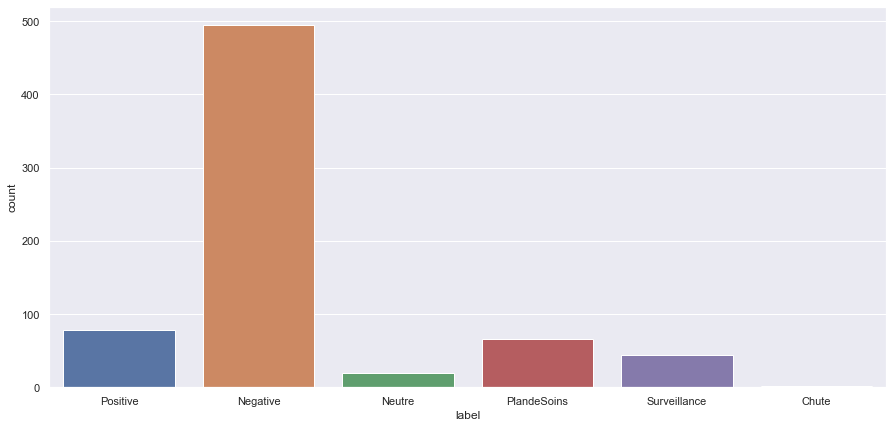

In [83]:
sns.set(rc={'figure.figsize':(15,7)})
sns.countplot(x='label', data=df)

In [143]:
display(df.groupby(['label'])['description'].count())
display(df['label'].unique())
display(df['label_num'].unique())

label
Chute             2
Negative        495
Neutre           20
PlandeSoins      66
Positive         78
Surveillance     44
Name: description, dtype: int64

array(['Positive', 'Negative', 'Neutre', 'PlandeSoins', 'Surveillance',
       'Chute'], dtype=object)

array([4, 1, 2, 3, 5, 0])

In [184]:
label = pd.DataFrame([{'Positive':4, 'Negative':1, 'Neutre':2, 'PlandeSoins':3, 'Surveillance':5, 'Chute':0}])


In [173]:
texts = df['description'].astype('str')

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df = 2, 
                                   max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
y = df['label_num'].values #target

X.shape, y.shape

((705, 2778), (705,))

In [174]:
import cv2

In [175]:
# print idf values
df_idf = pd.DataFrame(tfidf_vectorizer.idf_, index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights']).head(10)

,idf_weights
de,1.687497
la,2.147969
et,2.156938
ce,2.417952
en,2.447627
mme,2.459749
le,2.509759
au,2.509759
elle,2.576009
pas,2.780492


In [176]:
#tfidf_vectorizer.vocabulary_

In [177]:
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier()}

X_train, X_test, y_train, y_test = train_test_split(X.toarray(), 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

In [69]:
def model_score_df(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
    for k,v in model_dict.items():   
        model_name.append(k)
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='macro'))
        r_score_list.append(recall_score(y_test, y_pred, average='macro'))
        f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_score_df(model_dict)



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:143

,model_name,accuracy_score,precision_score,recall_score,f1_score
1,Stochastic Gradient Descent,0.792453,0.517914,0.371414,0.413646
5,Gaussian Naive Bayes,0.754717,0.481861,0.368567,0.405612
2,Random Forest,0.745283,0.458772,0.294069,0.33149
3,Decsision Tree,0.688679,0.335984,0.324607,0.329433
6,K Nearest Neighbor,0.735849,0.431231,0.267874,0.296194
4,AdaBoost,0.683962,0.265803,0.231612,0.221038
0,Dummy,0.542453,0.178611,0.175878,0.177192


In [178]:
SGD = SGDClassifier(random_state=3, loss='log')
SGD.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=3, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [179]:
y_pred = SGD.predict(X_test)
accuracy_score(y_test, y_pred)

0.7924528301886793

In [186]:
input_text = ["a surveiller", "il se sent bien", "IDE avertiea surveiller", "A disparu","tousse toujours",
             "présence de petits boutons rouge au niveau du torse"
             ]

input_counts = tfidf_vectorizer.transform(input_text)
predictions = SGD.predict(input_counts)

print(predictions)

for x in label:
    print(x)


[5 4 5 1 1 1]
Chute
Negative
Neutre
PlandeSoins
Positive
Surveillance


In [185]:
label.head()

,Chute,Negative,Neutre,PlandeSoins,Positive,Surveillance
0,0,1,2,3,4,5
